In [1]:
import pandas as pd
import os
import hvplot.pandas
import copy
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('precision',2)

In [2]:
current_dir = os.getcwd()
inputfile = current_dir + "/DATA/VOLUME_OVERVIEW.csv"

In [3]:
df = pd.read_csv(inputfile)
print(df.shape)
print(df.dtypes)
df.head()

(97464, 10)
FilerTimestamp     object
Volume_Name        object
total_ops         float64
read_data         float64
write_data        float64
total_data        float64
avg_latency       float64
concurrency       float64
parent_aggr        object
Hostname           object
dtype: object


,FilerTimestamp,Volume_Name,total_ops,read_data,write_data,total_data,avg_latency,concurrency,parent_aggr,Hostname
0,12/9/19 22:20,C1000FS003,103.22,4.75e+06,7.83e+05,5.54e+06,1222.63,126.20,prtntap01_04_tier03_aggr01,prtntap01-04
1,12/9/19 23:20,C1000FS003,385.03,2.13e+07,2.09e+06,2.34e+07,956.69,368.35,prtntap01_04_tier03_aggr01,prtntap01-04
2,13/9/19 0:20,C1000FS003,58.80,1.35e+06,1.13e+06,2.48e+06,2472.78,145.41,prtntap01_04_tier03_aggr01,prtntap01-04
3,13/9/19 1:20,C1000FS003,52.84,1.19e+06,1.02e+06,2.20e+06,2536.56,134.03,prtntap01_04_tier03_aggr01,prtntap01-04
4,13/9/19 2:20,C1000FS003,42.39,9.05e+05,7.46e+05,1.65e+06,2027.46,85.95,prtntap01_04_tier03_aggr01,prtntap01-04


In [4]:
df['FilerTimestamp'] = pd.to_datetime(df['FilerTimestamp'])
print(df.dtypes)
df.head()

FilerTimestamp    datetime64[ns]
Volume_Name               object
total_ops                float64
read_data                float64
write_data               float64
total_data               float64
avg_latency              float64
concurrency              float64
parent_aggr               object
Hostname                  object
dtype: object


,FilerTimestamp,Volume_Name,total_ops,read_data,write_data,total_data,avg_latency,concurrency,parent_aggr,Hostname
0,2019-12-09 22:20:00,C1000FS003,103.22,4.75e+06,7.83e+05,5.54e+06,1222.63,126.20,prtntap01_04_tier03_aggr01,prtntap01-04
1,2019-12-09 23:20:00,C1000FS003,385.03,2.13e+07,2.09e+06,2.34e+07,956.69,368.35,prtntap01_04_tier03_aggr01,prtntap01-04
2,2019-09-13 00:20:00,C1000FS003,58.80,1.35e+06,1.13e+06,2.48e+06,2472.78,145.41,prtntap01_04_tier03_aggr01,prtntap01-04
3,2019-09-13 01:20:00,C1000FS003,52.84,1.19e+06,1.02e+06,2.20e+06,2536.56,134.03,prtntap01_04_tier03_aggr01,prtntap01-04
4,2019-09-13 02:20:00,C1000FS003,42.39,9.05e+05,7.46e+05,1.65e+06,2027.46,85.95,prtntap01_04_tier03_aggr01,prtntap01-04


In [5]:
print(df.shape)
df = df.dropna(subset=['parent_aggr'])
print(df.shape)
df['Volume_Name'] = df['Hostname'] + ':' + df['parent_aggr'] + ':' +df['Volume_Name']
df['parent_aggr'] = df['Hostname'] + ':' + df['parent_aggr']
df.head()

(97464, 10)
(92965, 10)


,FilerTimestamp,Volume_Name,total_ops,read_data,write_data,total_data,avg_latency,concurrency,parent_aggr,Hostname
0,2019-12-09 22:20:00,prtntap01-04:prtntap01_04_tier03_aggr01:C1000F...,103.22,4.75e+06,7.83e+05,5.54e+06,1222.63,126.20,prtntap01-04:prtntap01_04_tier03_aggr01,prtntap01-04
1,2019-12-09 23:20:00,prtntap01-04:prtntap01_04_tier03_aggr01:C1000F...,385.03,2.13e+07,2.09e+06,2.34e+07,956.69,368.35,prtntap01-04:prtntap01_04_tier03_aggr01,prtntap01-04
2,2019-09-13 00:20:00,prtntap01-04:prtntap01_04_tier03_aggr01:C1000F...,58.80,1.35e+06,1.13e+06,2.48e+06,2472.78,145.41,prtntap01-04:prtntap01_04_tier03_aggr01,prtntap01-04
3,2019-09-13 01:20:00,prtntap01-04:prtntap01_04_tier03_aggr01:C1000F...,52.84,1.19e+06,1.02e+06,2.20e+06,2536.56,134.03,prtntap01-04:prtntap01_04_tier03_aggr01,prtntap01-04
4,2019-09-13 02:20:00,prtntap01-04:prtntap01_04_tier03_aggr01:C1000F...,42.39,9.05e+05,7.46e+05,1.65e+06,2027.46,85.95,prtntap01-04:prtntap01_04_tier03_aggr01,prtntap01-04


In [6]:
def average_results(df, aggregate_column='total_ops' ,categorical_col = 'Volume_Name', master_col = 'Hostname',sort_col_num = 2, ascending=False):
    """
    aggregate_column: [total_ops, read_data, write_data, total_data, avg_latency, concurrency]
    categorical_col = [Volume_Name , parent_aggr]
    sort_by = [ALL, Biz_Hours, After_Hours]
    sort_col = [average_ALL, average_Biz_Hours, average_After_Hours, percentage_ALL, percentage_Biz_Hours, percentage_After_Hours]
    ascending = [True, False]
    """
    print('Relation Between : %s & %s\n'%(categorical_col, master_col))
    cat_to_master = dict(list(zip(df[categorical_col],df[master_col])))
    df = df.set_index('FilerTimestamp')
    df_business_hours = df[(df.index.hour >=8) & (df.index.hour <=18)].reset_index()
    df_after_hours = df[(df.index.hour <8) | (df.index.hour >18)].reset_index()
    df = df.reset_index()
    
    pct_col_name = '%_Of_'+aggregate_column
    avg_col_name = 'Avg_'+aggregate_column
    intermediate_col = master_col + '_Total'
    ## Total Logic
    df_total_average = df.groupby(by=[categorical_col]).mean()[[aggregate_column]].rename(columns={aggregate_column: avg_col_name})
    
    df_total_pct = df.groupby(by=[categorical_col]).sum()[[aggregate_column]].rename(columns={aggregate_column: pct_col_name})
    df_total = df_total_average.join(df_total_pct)
    
    hostwise_sum_all = df.groupby(by =[master_col]).sum()[[aggregate_column]]
    df_total[intermediate_col] = [hostwise_sum_all.loc[cat_to_master[vol]][0] for vol in df_total.index]
    df_total[pct_col_name] = df_total[pct_col_name] * 100 / df_total[intermediate_col]
    df_total = df_total.drop(intermediate_col, axis=1)
    #print('\nTotal Usage All Hours: ', hostwise_sum_all)

    ## Business Hours Logic
    df_biz_hours_average = df_business_hours.groupby(by=[categorical_col]).mean()[[aggregate_column]].rename(columns={aggregate_column:avg_col_name})
    
    df_biz_hours_pct = df_business_hours.groupby(by=[categorical_col]).sum()[[aggregate_column]].rename(columns={aggregate_column:pct_col_name})
    df_biz_hours = df_biz_hours_average.join(df_biz_hours_pct)
    
    hostwise_sum_biz = df_business_hours.groupby(by =[master_col]).sum()[[aggregate_column]]
    df_biz_hours[intermediate_col] = [hostwise_sum_biz.loc[cat_to_master[vol]][0] for vol in df_biz_hours.index]
    df_biz_hours_pct = df_biz_hours_pct.fillna(0)
    df_biz_hours[pct_col_name] = df_biz_hours[pct_col_name] * 100 / df_biz_hours[intermediate_col]
    df_biz_hours = df_biz_hours.drop(intermediate_col, axis=1)    
    #print('\nTotal Usage Business Hours : ',hostwise_sum_biz)
    
    ## After Hours Logic
    df_after_hours_average = df_after_hours.groupby(by=[categorical_col]).mean()[[aggregate_column]].rename(columns={aggregate_column:avg_col_name})
    
    df_after_hours_pct = df_after_hours.groupby(by=[categorical_col]).sum()[[aggregate_column]].rename(columns={aggregate_column:pct_col_name})
    df_aftr_hours = df_after_hours_average.join(df_after_hours_pct)
    
    hostwise_sum_after = df_after_hours.groupby(by =[master_col]).sum()[[aggregate_column]]
    df_aftr_hours[intermediate_col] = [hostwise_sum_after.loc[cat_to_master[vol]][0] for vol in df_aftr_hours.index]
    df_after_hours_pct = df_after_hours_pct.fillna(0)
    df_aftr_hours[pct_col_name] = df_aftr_hours[pct_col_name] * 100 / df_aftr_hours[intermediate_col]
    df_aftr_hours = df_aftr_hours.drop(intermediate_col, axis=1)    
    df_aftr_hours.columns = [avg_col_name+'_After_Hrs',pct_col_name+'_After_Hrs']
    #print('\nTotal usage After Hours : ',hostwise_sum_after)
    
    final_df = df_total.join(df_biz_hours, lsuffix = '_All_Hrs', rsuffix = '_Biz_Hrs').join(df_aftr_hours)
    
    final_df[master_col] = [val[1] if master_col == 'parent_aggr' else val[0]  for val in final_df.index.str.split(':')]
    final_df = final_df.reset_index()
    columns = final_df.columns.tolist()
    columns.remove(master_col)
    columns.insert(0,master_col)
    final_df = final_df[columns]
    return final_df.sort_values(final_df.columns[sort_col_num], ascending=ascending)

In [7]:
with pd.ExcelWriter('output.xlsx') as writer:
    final_df_total_ops_by_volume_per_host = average_results(df, categorical_col='Volume_Name')
    print('\ntotal_ops_by_volume_by_per_host : ',final_df_total_ops_by_volume_per_host.shape)
    final_df_total_ops_by_volume_per_host.to_excel(writer,sheet_name='ops_by_volume_per_host', index=False)
    final_df_total_ops_by_volume_per_host.to_csv('ops_by_volume_per_host.csv', index=False)
    print()
    
    final_df_total_ops_by_parent_aggr_per_host = average_results(df, categorical_col='parent_aggr')
    print('\ntotal_ops_by_parent_aggr_by_per_host : ',final_df_total_ops_by_parent_aggr_per_host.shape)
    final_df_total_ops_by_parent_aggr_per_host.to_excel(writer,sheet_name='ops_by_parent_aggr_per_host',index=False)
    final_df_total_ops_by_parent_aggr_per_host.to_csv('ops_by_parent_aggr_per_host.csv',index=False)
    print()
    
    final_df_total_ops_by_volume_per_parent_aggr = average_results(df, categorical_col='Volume_Name', master_col='parent_aggr')
    print('\ntotal_ops_by_volume_per_parent_aggr : ',final_df_total_ops_by_volume_per_parent_aggr.shape)
    final_df_total_ops_by_volume_per_parent_aggr.to_excel(writer,sheet_name='ops_by_volume_per_parent_aggr',index=False)
    final_df_total_ops_by_volume_per_parent_aggr.to_csv('ops_by_volume_per_parent_aggr.csv',index=False)
    print()

Relation Between : Volume_Name & Hostname


total_ops_by_volume_by_per_host :  (306, 8)

Relation Between : parent_aggr & Hostname


total_ops_by_parent_aggr_by_per_host :  (27, 8)

Relation Between : Volume_Name & parent_aggr


total_ops_by_volume_per_parent_aggr :  (306, 8)



In [8]:
final_df_total_ops_by_volume_per_host.head(10)

,Hostname,Volume_Name,Avg_total_ops_All_Hrs,%_Of_total_ops_All_Hrs,Avg_total_ops_Biz_Hrs,%_Of_total_ops_Biz_Hrs,Avg_total_ops_After_Hrs,%_Of_total_ops_After_Hrs
283,prtntap01-04,prtntap01-04:prtntap01_04_tier02_aggr01:STANDA...,3785.01,34.17,2860.73,27.31,4586.06,39.54
240,prtntap01-03,prtntap01-03:prtntap01_03_tier02_aggr01:C1040V...,3563.62,21.51,4160.05,25.93,3046.72,17.90
52,mtcntap01-03,mtcntap01-03:mtcntap01_03_tier02_aggr01:C1064_...,2185.64,9.45,1854.92,8.31,2468.32,10.35
5,aus-mel-a700-01,aus-mel-a700-01:mtcntap01_05_ssd:C1027REP004_S003,2057.79,51.16,1938.56,58.56,2199.10,45.19
262,prtntap01-03,prtntap01-03:prtntap01_03_tier03_aggr01:C1050F...,1874.09,11.31,1777.87,11.08,1957.47,11.50
12,aus-mel-a700-02,aus-mel-a700-02:mtcntap01_06_ssd:C1050REPFS001,1850.49,92.07,1837.44,92.69,1865.48,91.36
81,mtcntap01-03,mtcntap01-03:mtcntap01_03_tier03_aggr01:C1032R...,1586.16,6.86,1135.40,5.09,1971.44,8.27
238,prtntap01-03,prtntap01-03:prtntap01_03_tier02_aggr01:C1032F...,1546.63,9.34,1413.40,8.81,1662.10,9.77
254,prtntap01-03,prtntap01-03:prtntap01_03_tier03_aggr01:C1032F...,1456.24,8.79,1257.00,7.83,1628.91,9.57
127,mtcntap01-04,mtcntap01-04:mtcntap01_04_tier02_aggr01:C1027R...,1393.05,7.30,1408.86,7.05,1379.43,7.53


In [9]:
final_df_total_ops_by_parent_aggr_per_host.head(10)

,Hostname,parent_aggr,Avg_total_ops_All_Hrs,%_Of_total_ops_All_Hrs,Avg_total_ops_Biz_Hrs,%_Of_total_ops_Biz_Hrs,Avg_total_ops_After_Hrs,%_Of_total_ops_After_Hrs
5,aus-mel-a700-02,aus-mel-a700-02:mtcntap01_06_ssd,1210.24,95.51,1310.21,95.95,1114.53,95.02
25,prtntap01-04,prtntap01-04:prtntap01_04_tier02_aggr01,861.15,85.52,803.70,84.40,910.94,86.39
18,prtntap01-01,prtntap01-01:prtntap01_01_tier01_aggr02,651.99,26.26,630.01,27.29,671.05,25.47
22,prtntap01-03,prtntap01-03:prtntap01_03_tier02_aggr01,631.94,61.04,628.15,62.64,635.23,59.73
2,aus-mel-a700-01,aus-mel-a700-01:mtcntap01_05_ssd,567.51,97.09,523.92,96.94,608.19,97.22
11,mtcntap01-03,mtcntap01-03:mtcntap01_03_tier02_aggr01,400.81,60.55,390.28,61.15,409.81,60.07
20,prtntap01-02,prtntap01-02:prtntap01_02_tier01_aggr01,380.84,88.78,368.68,88.65,391.45,88.88
17,prtntap01-01,prtntap01-01:prtntap01_01_tier01_aggr01,355.07,71.50,325.10,70.42,381.05,72.32
23,prtntap01-03,prtntap01-03:prtntap01_03_tier03_aggr01,303.94,38.53,282.18,36.93,322.79,39.84
14,mtcntap01-04,mtcntap01-04:mtcntap01_04_tier02_aggr01,277.91,53.77,302.17,55.97,256.92,51.69


In [10]:
final_df_total_ops_by_volume_per_parent_aggr.head(10)

,parent_aggr,Volume_Name,Avg_total_ops_All_Hrs,%_Of_total_ops_All_Hrs,Avg_total_ops_Biz_Hrs,%_Of_total_ops_Biz_Hrs,Avg_total_ops_After_Hrs,%_Of_total_ops_After_Hrs
283,prtntap01_04_tier02_aggr01,prtntap01-04:prtntap01_04_tier02_aggr01:STANDA...,3785.01,39.96,2860.73,32.36,4586.06,45.77
240,prtntap01_03_tier02_aggr01,prtntap01-03:prtntap01_03_tier02_aggr01:C1040V...,3563.62,35.24,4160.05,41.39,3046.72,29.98
52,mtcntap01_03_tier02_aggr01,mtcntap01-03:mtcntap01_03_tier02_aggr01:C1064_...,2185.64,15.60,1854.92,13.59,2468.32,17.24
5,mtcntap01_05_ssd,aus-mel-a700-01:mtcntap01_05_ssd:C1027REP004_S003,2057.79,52.69,1938.56,60.41,2199.10,46.49
262,prtntap01_03_tier03_aggr01,prtntap01-03:prtntap01_03_tier03_aggr01:C1050F...,1874.09,29.36,1777.87,30.00,1957.47,28.88
12,mtcntap01_06_ssd,aus-mel-a700-02:mtcntap01_06_ssd:C1050REPFS001,1850.49,96.40,1837.44,96.61,1865.48,96.15
81,mtcntap01_03_tier03_aggr01,mtcntap01-03:mtcntap01_03_tier03_aggr01:C1032R...,1586.16,17.55,1135.40,13.23,1971.44,20.90
238,prtntap01_03_tier02_aggr01,prtntap01-03:prtntap01_03_tier02_aggr01:C1032F...,1546.63,15.30,1413.40,14.06,1662.10,16.35
254,prtntap01_03_tier03_aggr01,prtntap01-03:prtntap01_03_tier03_aggr01:C1032F...,1456.24,22.82,1257.00,21.21,1628.91,24.03
127,mtcntap01_04_tier02_aggr01,mtcntap01-04:mtcntap01_04_tier02_aggr01:C1027R...,1393.05,13.58,1408.86,12.60,1379.43,14.58


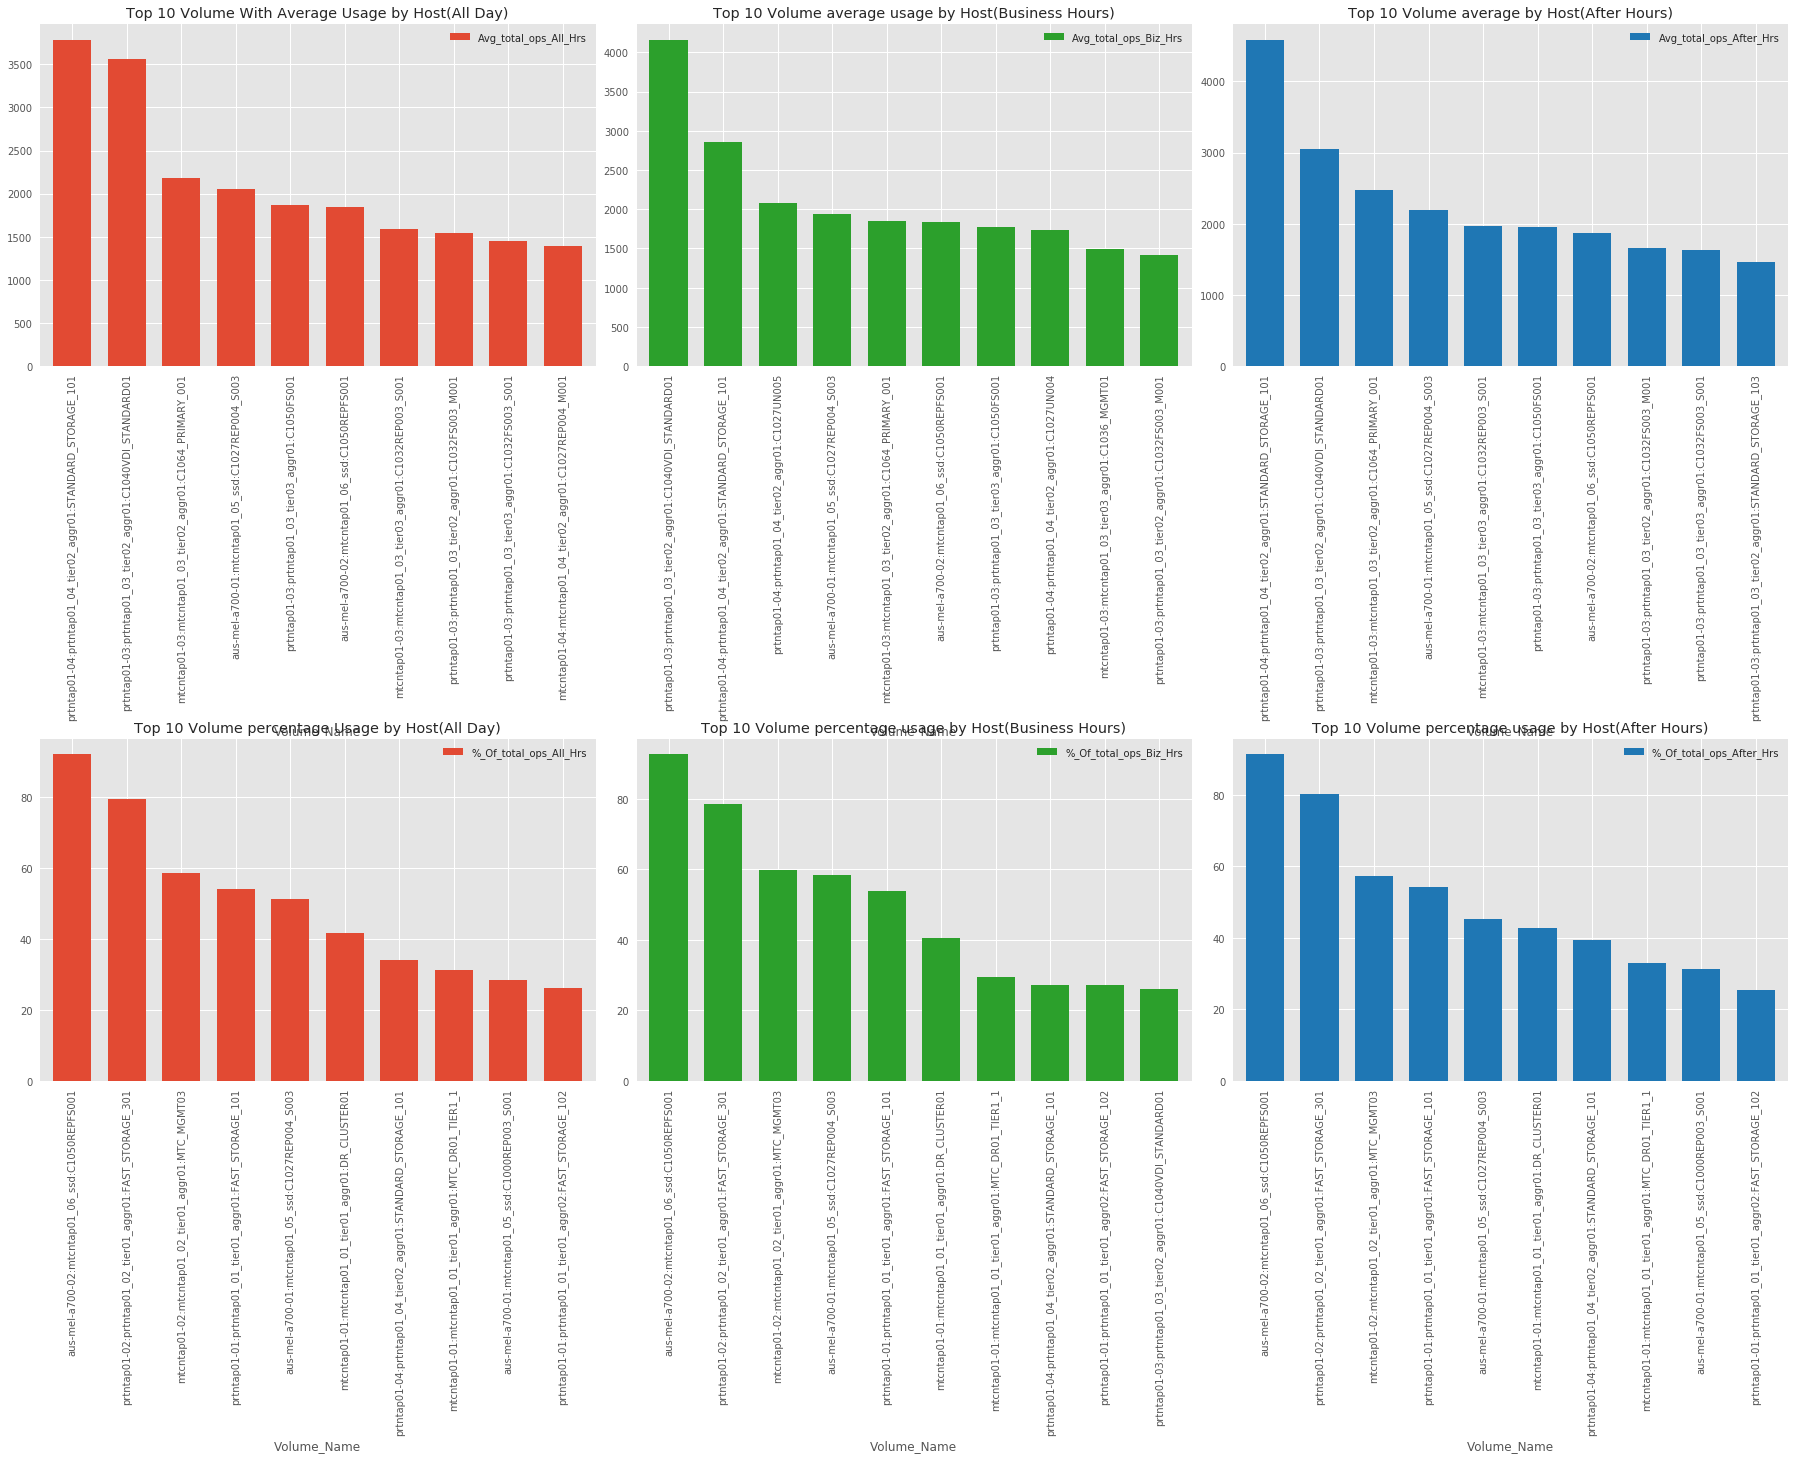

In [11]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,20))
    ax1 = plt.subplot(2,3,1)
    final_df_total_ops_by_volume_per_host[['Volume_Name','Avg_total_ops_All_Hrs']].sort_values(by='Avg_total_ops_All_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='Avg_total_ops_All_Hrs', kind='bar', ax = ax1, width=0.7, title='Top 10 Volume With Average Usage by Host(All Day)');
    ax2 = plt.subplot(2,3,2)
    final_df_total_ops_by_volume_per_host[['Volume_Name','Avg_total_ops_Biz_Hrs']].sort_values(by='Avg_total_ops_Biz_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='Avg_total_ops_Biz_Hrs', kind='bar',ax=ax2, width=0.7, color='tab:green', title='Top 10 Volume average usage by Host(Business Hours)');
    ax3 = plt.subplot(2,3,3)
    final_df_total_ops_by_volume_per_host[['Volume_Name','Avg_total_ops_After_Hrs']].sort_values(by='Avg_total_ops_After_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='Avg_total_ops_After_Hrs', kind='bar',ax=ax3, width=0.7, color='tab:blue', title='Top 10 Volume average by Host(After Hours)');
    
    ax4 = plt.subplot(2,3,4)
    final_df_total_ops_by_volume_per_host[['Volume_Name','%_Of_total_ops_All_Hrs']].sort_values(by='%_Of_total_ops_All_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='%_Of_total_ops_All_Hrs', kind='bar', ax = ax4, width=0.7, title='Top 10 Volume percentage Usage by Host(All Day)');
    ax5 = plt.subplot(2,3,5)
    final_df_total_ops_by_volume_per_host[['Volume_Name','%_Of_total_ops_Biz_Hrs']].sort_values(by='%_Of_total_ops_Biz_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='%_Of_total_ops_Biz_Hrs', kind='bar',ax=ax5, width=0.7, color='tab:green', title='Top 10 Volume percentage usage by Host(Business Hours)');
    ax6 = plt.subplot(2,3,6)
    final_df_total_ops_by_volume_per_host[['Volume_Name','%_Of_total_ops_After_Hrs']].sort_values(by='%_Of_total_ops_After_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='%_Of_total_ops_After_Hrs', kind='bar',ax=ax6, width=0.7, color='tab:blue', title='Top 10 Volume percentage usage by Host(After Hours)');
    plt.tight_layout()
    
    plt.savefig('Total_Ops_Analysis_By_Volume_Per_Hostname.png')

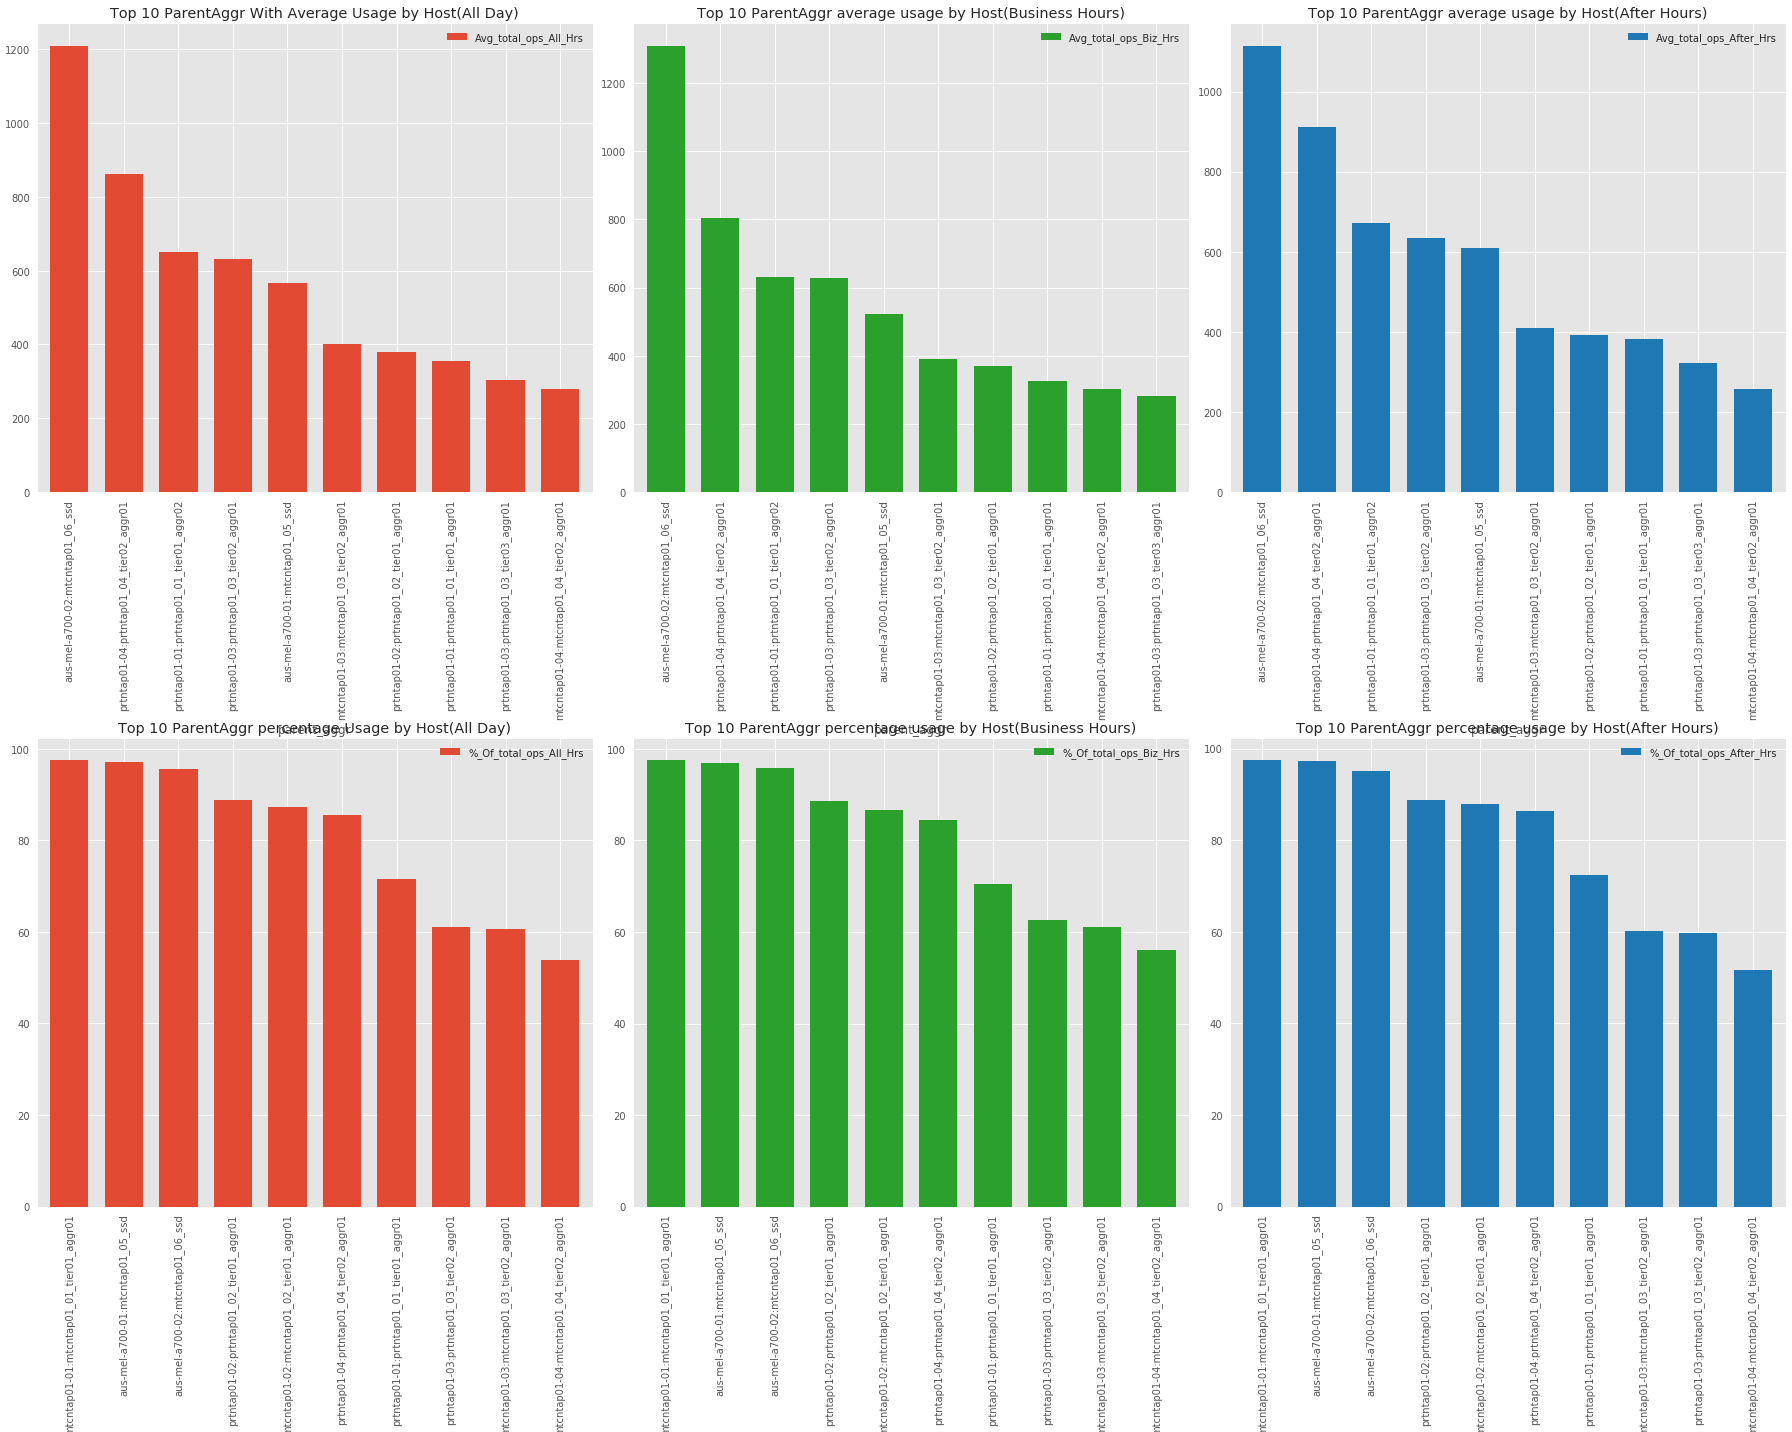

In [12]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,20))
    ax1 = plt.subplot(2,3,1)
    final_df_total_ops_by_parent_aggr_per_host[['parent_aggr','Avg_total_ops_All_Hrs']].sort_values(by='Avg_total_ops_All_Hrs', ascending=False).head(10).plot(x='parent_aggr',y='Avg_total_ops_All_Hrs', kind='bar', ax = ax1, width=0.7, title='Top 10 ParentAggr With Average Usage by Host(All Day)');
    ax2 = plt.subplot(2,3,2)
    final_df_total_ops_by_parent_aggr_per_host[['parent_aggr','Avg_total_ops_Biz_Hrs']].sort_values(by='Avg_total_ops_Biz_Hrs', ascending=False).head(10).plot(x='parent_aggr',y='Avg_total_ops_Biz_Hrs', kind='bar',ax=ax2, width=0.7, color='tab:green', title='Top 10 ParentAggr average usage by Host(Business Hours)');
    ax3 = plt.subplot(2,3,3)
    final_df_total_ops_by_parent_aggr_per_host[['parent_aggr','Avg_total_ops_After_Hrs']].sort_values(by='Avg_total_ops_After_Hrs', ascending=False).head(10).plot(x='parent_aggr',y='Avg_total_ops_After_Hrs', kind='bar',ax=ax3, width=0.7, color='tab:blue', title='Top 10 ParentAggr average usage by Host(After Hours)');
    
    ax4 = plt.subplot(2,3,4)
    final_df_total_ops_by_parent_aggr_per_host[['parent_aggr','%_Of_total_ops_All_Hrs']].sort_values(by='%_Of_total_ops_All_Hrs', ascending=False).head(10).plot(x='parent_aggr',y='%_Of_total_ops_All_Hrs', kind='bar', ax = ax4, width=0.7, title='Top 10 ParentAggr percentage Usage by Host(All Day)');
    ax5 = plt.subplot(2,3,5)
    final_df_total_ops_by_parent_aggr_per_host[['parent_aggr','%_Of_total_ops_Biz_Hrs']].sort_values(by='%_Of_total_ops_Biz_Hrs', ascending=False).head(10).plot(x='parent_aggr',y='%_Of_total_ops_Biz_Hrs', kind='bar',ax=ax5, width=0.7, color='tab:green', title='Top 10 ParentAggr percentage usage by Host(Business Hours)');
    ax6 = plt.subplot(2,3,6)
    final_df_total_ops_by_parent_aggr_per_host[['parent_aggr','%_Of_total_ops_After_Hrs']].sort_values(by='%_Of_total_ops_After_Hrs', ascending=False).head(10).plot(x='parent_aggr',y='%_Of_total_ops_After_Hrs', kind='bar',ax=ax6, width=0.7, color='tab:blue', title='Top 10 ParentAggr percentage usage by Host(After Hours)');
    plt.tight_layout()
    
    plt.savefig('Total_Ops_Analysis_By_ParentAggr_Per_Hostname.png')

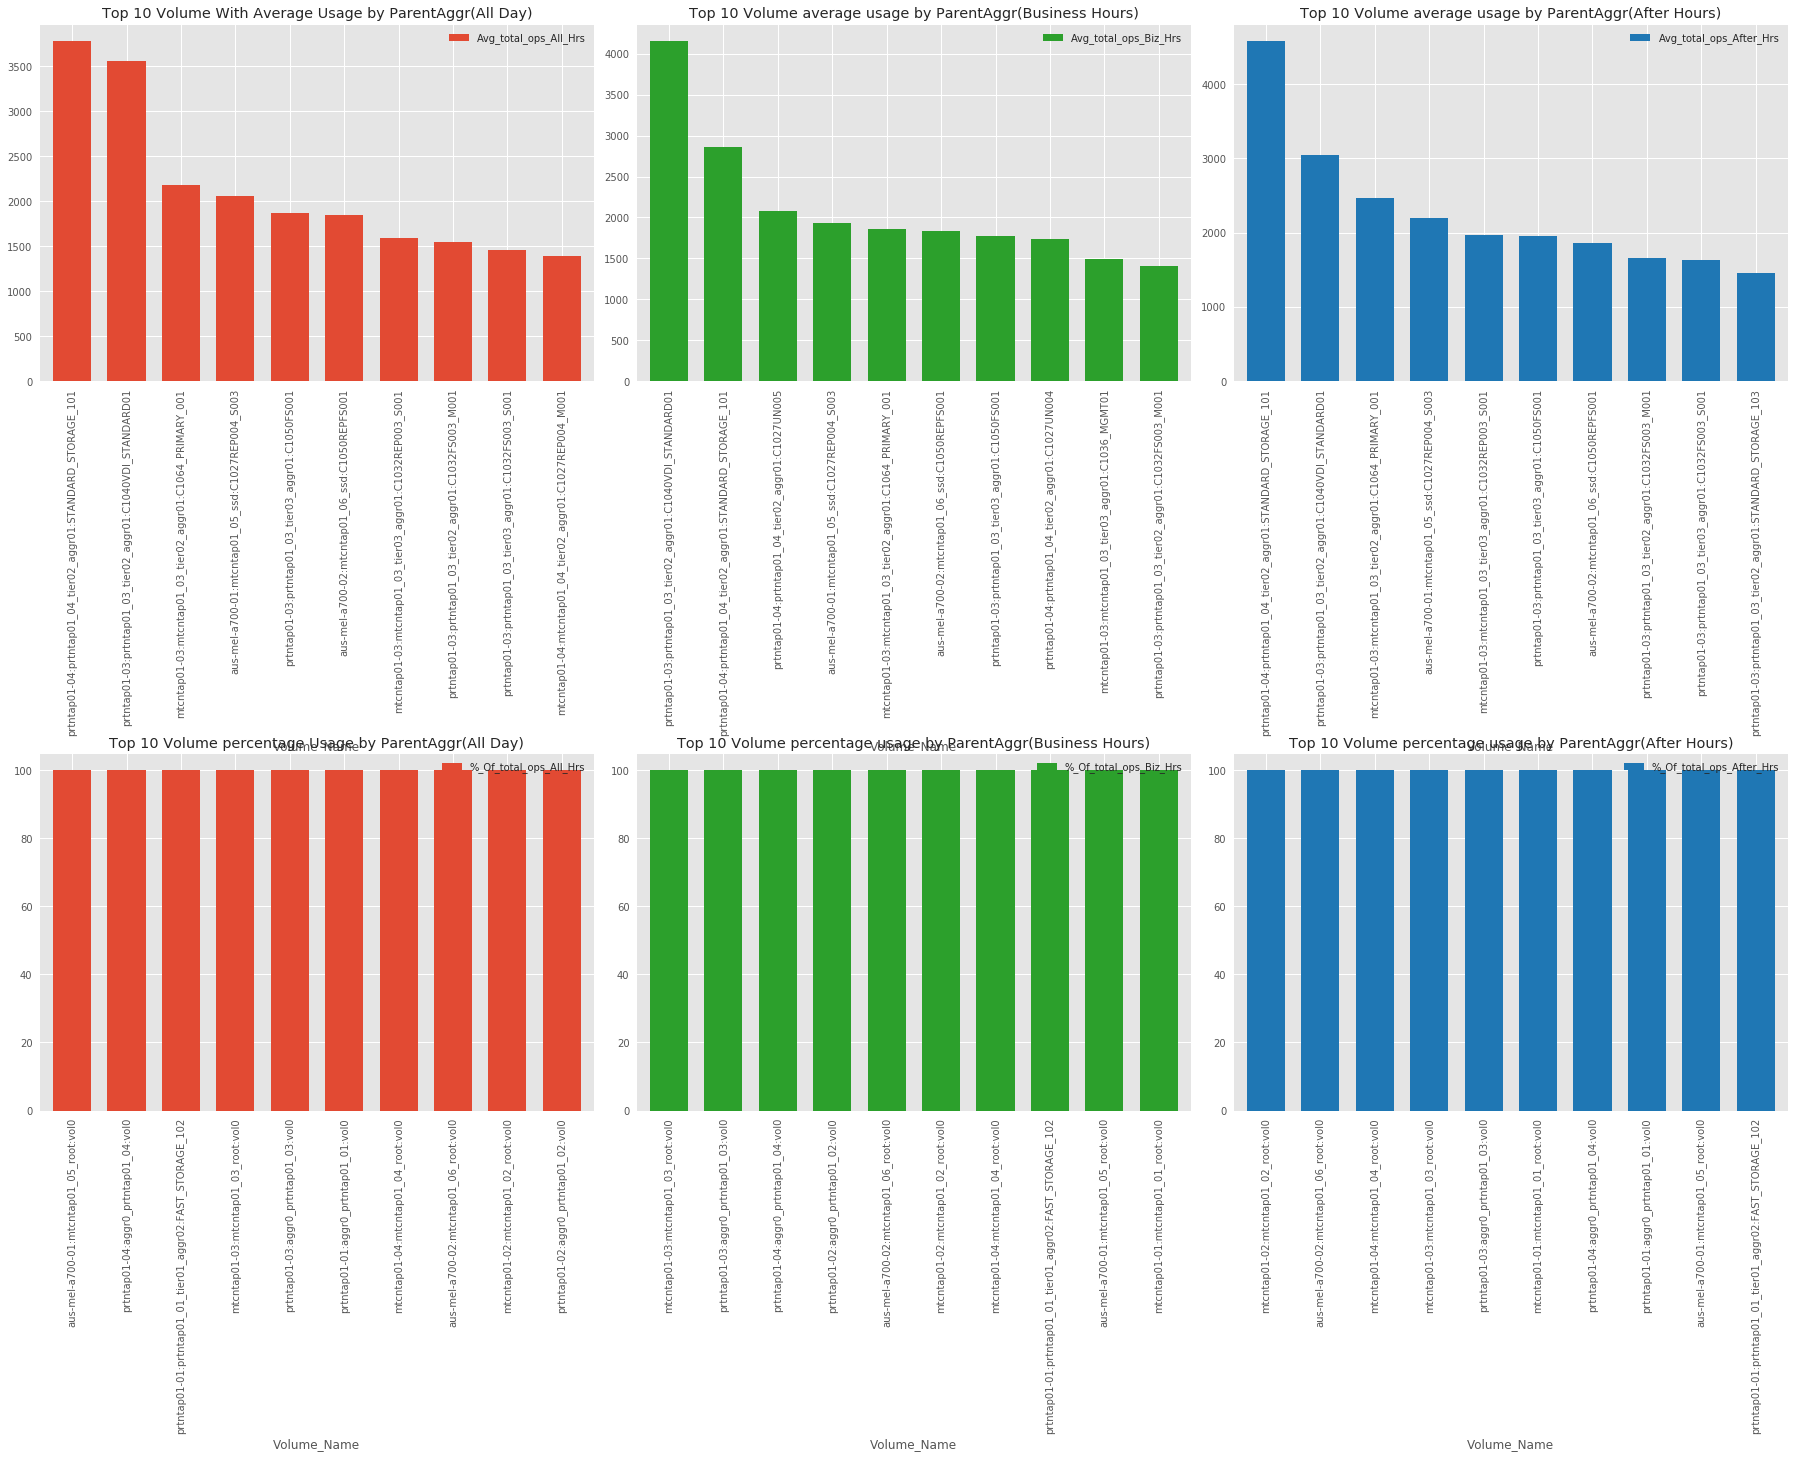

In [13]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,20))
    ax1 = plt.subplot(2,3,1)
    final_df_total_ops_by_volume_per_parent_aggr[['Volume_Name','Avg_total_ops_All_Hrs']].sort_values(by='Avg_total_ops_All_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='Avg_total_ops_All_Hrs', kind='bar', ax = ax1, width=0.7, title='Top 10 Volume With Average Usage by ParentAggr(All Day)');
    ax2 = plt.subplot(2,3,2)
    final_df_total_ops_by_volume_per_parent_aggr[['Volume_Name','Avg_total_ops_Biz_Hrs']].sort_values(by='Avg_total_ops_Biz_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='Avg_total_ops_Biz_Hrs', kind='bar',ax=ax2, width=0.7, color='tab:green', title='Top 10 Volume average usage by ParentAggr(Business Hours)');
    ax3 = plt.subplot(2,3,3)
    final_df_total_ops_by_volume_per_parent_aggr[['Volume_Name','Avg_total_ops_After_Hrs']].sort_values(by='Avg_total_ops_After_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='Avg_total_ops_After_Hrs', kind='bar',ax=ax3, width=0.7, color='tab:blue', title='Top 10 Volume average usage by ParentAggr(After Hours)');
    
    ax4 = plt.subplot(2,3,4)
    final_df_total_ops_by_volume_per_parent_aggr[['Volume_Name','%_Of_total_ops_All_Hrs']].sort_values(by='%_Of_total_ops_All_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='%_Of_total_ops_All_Hrs', kind='bar', ax = ax4, width=0.7, title='Top 10 Volume percentage Usage by ParentAggr(All Day)');
    ax5 = plt.subplot(2,3,5)
    final_df_total_ops_by_volume_per_parent_aggr[['Volume_Name','%_Of_total_ops_Biz_Hrs']].sort_values(by='%_Of_total_ops_Biz_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='%_Of_total_ops_Biz_Hrs', kind='bar',ax=ax5, width=0.7, color='tab:green', title='Top 10 Volume percentage usage by ParentAggr(Business Hours)');
    ax6 = plt.subplot(2,3,6)
    final_df_total_ops_by_volume_per_parent_aggr[['Volume_Name','%_Of_total_ops_After_Hrs']].sort_values(by='%_Of_total_ops_After_Hrs', ascending=False).head(10).plot(x='Volume_Name',y='%_Of_total_ops_After_Hrs', kind='bar',ax=ax6, width=0.7, color='tab:blue', title='Top 10 Volume percentage usage by ParentAggr(After Hours)');
    plt.tight_layout()
    
    plt.savefig('Total_Ops_Analysis_By_Volume_Per_ParentAggr.png')